In [8]:
import os
import pandas as pd
import multiprocessing
import scipy as sp
import numpy as np
import time
import matplotlib.pyplot as plt
import tensorflow as tf
import librosa
import librosa.display

## Experimentation with Tensorflow Audio Processing ##
In this notebook, we will be experimenting with audio processing using
tensorflow. We will be converting the data processing pipeline
as shown in working.ipynb to accomodate STFTs and Spectrogram 
generation using the GPU instead of just the CPU. This should result in
significant speedups in data processing.

To begin, we set the new working directory and grab some files to play with.

In [9]:
working_dir = r'D:\fma_large'
file_list = []
for folder in os.listdir(working_dir):
    file_list += ([working_dir+'\\'+folder+'\\'+file for file in os.listdir(working_dir+'\\'+folder) if '.mp3' in file])

In [10]:
test_list = file_list[:1000]
#print(test_list)
test_file = file_list[0]
print(test_file)

D:\fma_large\000\000002.mp3


We'll be following the details as described in https://medium.com/swlh/how-to-run-gpu-accelerated-signal-processing-in-tensorflow-13e1633f4bfb

One problem we may run into using Tensorflow for audio processing on Windows
is the use of ffmpeg to load the audio data. If this issue exists, then
we'll resort to using either scipy or librosa to extract the audio waveform.

In [12]:
sampling_rate = 44100
audio_binary = tf.io.read_file(test_file)
# unfortunately conversion to .wav from .mp3 will be necessary for this
# switch to librosa

log helper function from https://towardsdatascience.com/how-to-easily-process-audio-on-your-gpu-with-tensorflow-2d9d91360f06

In [11]:
def power_to_db(S, amin=1e-16, top_db=80.0):
    """Convert a power-spectrogram (magnitude squared) to decibel (dB) units.
    Computes the scaling ``10 * log10(S / max(S))`` in a numerically
    stable way.
    Based on:
    https://librosa.github.io/librosa/generated/librosa.core.power_to_db.html
    """
    def _tf_log10(x):
        numerator = tf.math.log(x)
        denominator = tf.math.log(tf.constant(10, dtype=numerator.dtype))
        return numerator / denominator
    
    # Scale magnitude relative to maximum value in S. Zeros in the output 
    # correspond to positions where S == ref.
    ref = tf.reduce_max(S)

    log_spec = 10.0 * _tf_log10(tf.maximum(amin, S))
    log_spec -= 10.0 * _tf_log10(tf.maximum(amin, ref))

    log_spec = tf.maximum(log_spec, tf.reduce_max(log_spec) - top_db)

    return log_spec

In [7]:
x, sr = librosa.load(test_file, sr=None, mono=True)
signals = tf.reshape(x, [1, -1])  # reshape to shape of (batch_size, samples)
stft = tf.signal.stft(signals, frame_length=2048, frame_step=512,
                     fft_length=2048)
mag_S = tf.abs(stft)

num_spectrogram_bins = mag_S.shape[-1]
lower_edge_hertz, upper_edge_hertz, num_mel_bins = 20.0, 20000, 64
linear_to_mel_weight_matrix = tf.signal.linear_to_mel_weight_matrix(
    num_mel_bins, num_spectrogram_bins, sr, lower_edge_hertz,
    upper_edge_hertz)
mel = tf.matmul(tf.square(mag_S), linear_to_mel_weight_matrix)
log_offset = 1e-6
log_mel = power_to_db(mel)


In [50]:
log_mel.shape

TensorShape([1, 2578, 64])

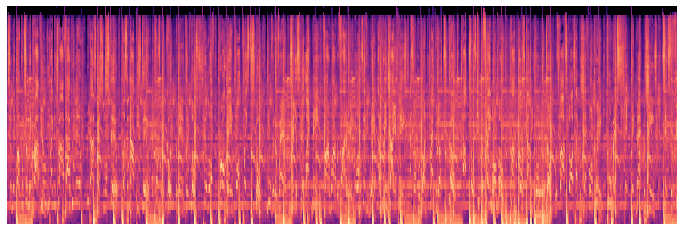

In [56]:
plt.figure(figsize=(12,4))
ax=plt.axes()
plt.set_cmap('hot')
ax.set_axis_off()
librosa.display.specshow(log_mel[0].numpy().T, y_axis='mel', x_axis='time', sr=sr, hop_length=512)


This seems to be working quite nicely. One thing that we might want
to try now is to do a time and image comparison for a singly threaded
implementation between the librosa data-processing pipeline in 
working.ipynb, and this one

In [12]:
def build_spectrogram_with_tf(file):
    try:
        x, sr = librosa.load(file, sr=None, mono=True)  # must use librosa for mp3, tf and sp.io only supports .wav
    except:
        print("Error with librosa on: ", file)
        return 0
    name = file
    x, sr = librosa.load(file, sr=None, mono=True)
    signals = tf.reshape(x, [1, -1])  # reshape to shape of (batch_size, samples)
    stft = tf.signal.stft(signals, frame_length=2048, frame_step=512,
                     fft_length=2048)
    mag_S = tf.abs(stft)
    num_spectrogram_bins = mag_S.shape[-1]
    lower_edge_hertz, upper_edge_hertz, num_mel_bins = 20, sr//2-1, 64  # upper edge to nyquist
    linear_to_mel_weight_matrix = tf.signal.linear_to_mel_weight_matrix(
        num_mel_bins, num_spectrogram_bins, sr, lower_edge_hertz,
        upper_edge_hertz)
    mel = tf.matmul(tf.square(mag_S), linear_to_mel_weight_matrix)
    log_mel = power_to_db(mel)
    plt.figure(figsize=(12,4))
    ax = plt.axes()
    plt.set_cmap('hot')
    ax.set_axis_off()
    librosa.display.specshow(log_mel[0].numpy().T, sr=sr, hop_length=512, x_axis='time', y_axis='mel')
    output_name = name.split('\\')[-1]
    output_name = output_name[:-4] + '.png'
    spectrogram_dir = r'D:\fma_large_spectrograms_tf'
    plt.savefig(spectrogram_dir+'\\'+output_name, bbox_inches='tight', transparent=True, pad_inches=0.0)
    plt.close()
    return None
    
def build_spectrogram_with_librosa(file):
    try:
        x, sr = librosa.load(file, sr=None, mono=True)
    except:
        print("Error with librosa on: ", file)
        return 0
    name = file
    spectrogram_dir = r'D:\fma_large_spectrograms_librosa'
    stft = np.abs(librosa.stft(x, n_fft=2048, hop_length=512))  # will reuse for remainder of spectral features
    mel = librosa.feature.melspectrogram(sr=sr, S=stft**2)
    log_mel = librosa.amplitude_to_db(mel)  # want to save the log_mel (dB conversion)
    plt.figure(figsize=(12,4))
    ax = plt.axes()
    plt.set_cmap('hot')
    ax.set_axis_off()
    librosa.display.specshow(log_mel, sr=sr, hop_length=512, x_axis='time', y_axis='mel')
    output_name = name.split("\\")[-1]
    output_name = output_name[:-4] + '.png'
    plt.savefig(spectrogram_dir+'\\'+output_name, bbox_inches='tight', transparent=True, pad_inches=0.0)
    plt.close()
    return None

In [7]:
time_start = time.time()
for piece in test_list:
    build_spectrogram_with_librosa(piece)
time_stop = time.time()
print("Total time is: ", time_stop-time_start)

Total time is:  77.37474822998047


In [20]:
time_start = time.time()
for piece in test_list:
    build_spectrogram_with_tf(piece)
time_stop = time.time()
print("Total time is: ", time_stop-time_start)

Total time is:  700.8465671539307


In [18]:
pngs = [file[:-4] for file in os.listdir(r'D:/fma_large_spectrograms_librosa/')]
remaining_files = [file for file in file_list if file.split("\\")[-1][:-4] not in pngs]

In [19]:
print(len(remaining_files))
print(remaining_files[0])

164
D:\fma_large\001\001486.mp3


The speedup is not a significant factor, but is appreciable. Let's take a look at a multiprocessed version.

In [16]:
import workers

In [20]:
time_start = time.time()
if __name__ == '__main__':
    with multiprocessing.Pool() as pool:
        pool.map(workers.build_spectrogram_with_librosa, remaining_files)
time_stop = time.time()
print("Total time is: ", time_stop-time_start)

ValueError: can't extend empty axis 0 using modes other than 'constant' or 'empty'

In [ ]:
# this results in a really bad memory leak
time_start = time.time()
if __name__ == '__main__':
    with multiprocessing.Pool() as pool:
        pool.map(workers.build_spectrogram_with_tf, test_list)
time_stop = time.time()
print("Total time is: ", time_stop-time_start)